# EDA 1 — Pre-Cleaning & Data Understanding

Purpose: Understand the dataset **before any feature engineering**, focusing on:
- Justifying cleaning steps (e.g., removing duplicates, dropping `language_code`)
- Identifying potential feature engineering needs (e.g., log transforms, binning)
- Highlighting possible issues in the raw data

In [1]:
import sys
import os
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts" / "eda1_prep"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Artifacts dir ready: {ARTIFACTS_DIR.exists()}")


Project root: c:\Users\User\Documents\book-recomendation
Artifacts dir ready: True


In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import json
import numpy as np
from scipy import stats

from src.ingest import load_books_csv
from src.eda import dup_checks, text_stats, plots
from src.eda.utils import set_eda_style, save_and_show
from src.clean.pipeline import clean_books_dataset
from src.eda.dup_checks import exact_title_author_dups, title_norm_author_overlap_dups, same_description_groups, same_description_dup
from src.eda.text_stats import author_flip_candidates

set_eda_style()
DATA_PATH = Path(PROJECT_ROOT / "data/raw/book.csv")

helper utils

In [3]:
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True) 

def _nan_ratio(s):
    return float(s.isna().mean())

def _skew_kurt(x):
    x = pd.Series(x).dropna()
    if len(x) < 10: 
        return np.nan, np.nan
    return float(stats.skew(x)), float(stats.kurtosis(x, fisher=True))

def _gini(x):
    x = np.asarray(pd.Series(x).dropna(), dtype=float)
    if len(x) == 0: 
        return np.nan
    x = np.sort(x)
    if x.min() < 0:
        x = x - x.min()
    if x.sum() == 0:
        return 0.0
    n = x.size
    cumx = np.cumsum(x)
    return float((n + 1 - 2 * (cumx.sum() / cumx[-1])) / n)

def _share_top(series, k=1):
    vc = series.value_counts(dropna=False)
    if len(vc) == 0: 
        return 0.0
    return float(vc.iloc[:k].sum() / vc.sum())

def _unique_ratio(series):
    n = series.shape[0]
    if n == 0: 
        return 0.0
    return float(series.nunique(dropna=False) / n)

def _is_lognormalish(x):
    skew, _ = _skew_kurt(x)
    g = _gini(x)
    return (not np.isnan(skew) and skew > 1.0) or (not np.isnan(g) and g > 0.5)

def _median_split_feature(s):
    s = pd.Series(s)
    if s.dropna().empty:
        return None
    return float(s.median())

def _decade_from_year(y):
    try:
        y = int(y)
        return int(y // 10 * 10)
    except Exception:
        return np.nan


auto recommendations core

In [4]:
def recommend_fe_actions(df: pd.DataFrame) -> dict:
    recos = {"generated_from": "10_eda1.ipynb", "actions": []}

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            nan_ratio = _nan_ratio(df[col])
            if nan_ratio > 0.1:
                recos["actions"].append({
                    "feature": col,
                    "action": "consider_imputation",
                    "why": f"column {col} has {nan_ratio:.2%} NaN values; consider imputation or dropping"
                })
            else:
                recos["actions"].append({
                    "feature": col,
                    "action": "keep",
                    "why": f"column {col} has acceptable NaN ratio ({nan_ratio:.2%})"
                })

    if "language_code" in df.columns:
        top_share = _share_top(df["language_code"])
        uniq_ratio = _unique_ratio(df["language_code"])
        reason_bits = [f"top_share={top_share:.3f}", f"unique_ratio={uniq_ratio:.3f}"]
        if top_share >= 0.50:
            recos["actions"].append({
                "feature": "language_code",
                "action": "drop",
                "why": "dominated by a single code; low discriminative value (" + ", ".join(reason_bits) + ")"
            })
        else:
            recos["actions"].append({
                "feature": "language_code",
                "action": "keep_but_downweight",
                "why": "not fully dominated; might still help filtering; consider one‑hot with regularization (" + ", ".join(reason_bits) + ")"
            })

    if "description" in df.columns:
        desc_len = df["description"].fillna("").str.split().map(len)
        skew, kurt = _skew_kurt(desc_len)
        med = _median_split_feature(desc_len)
        if _is_lognormalish(desc_len):
            recos["actions"].append({
                "feature": "desc_length",
                "action": "derive_log1p_and_binary",
                "why": f"length is right‑skewed (skew={skew:.2f}); add log1p(desc_len) and a binary above_median={med}"
            })
        else:
            recos["actions"].append({
                "feature": "desc_length",
                "action": "zscore_and_binary",
                "why": f"length roughly symmetric (skew={skew:.2f}); z‑score normalize and add binary above_median={med}"
            })

    if "authors" in df.columns:
        auth_count = df["authors"].fillna("").apply(lambda s: 0 if s.strip()=="" else len([a for a in s.split(",") if a.strip()]))
        med = _median_split_feature(auth_count)
        recos["actions"].append({
            "feature": "author_count",
            "action": "derive_integer_and_binary",
            "why": f"author_count is easy signal; add int feature and binary above_median={med}"
        })

    if "original_publication_year" in df.columns:
        y = pd.to_numeric(df["original_publication_year"], errors="coerce")
        y_valid = y.dropna()
        if not y_valid.empty:
            yr_skew, _ = _skew_kurt(y_valid)
            med = _median_split_feature(y_valid)
            recos["actions"].append({
                "feature": "original_publication_year",
                "action": "derive_decade_and_modern_flag",
                "why": f"year often non‑linear; add decade bucket and modern(>=2000). skew={yr_skew:.2f}, median={med:.0f}"
            })

    if "average_rating" in df.columns:
        r = pd.to_numeric(df["average_rating"], errors="coerce")
        r_valid = r.dropna()
        if not r_valid.empty:
            r_min, r_max = float(r_valid.min()), float(r_valid.max())
            r_std = float(r_valid.std(ddof=0))
            if r_max - r_min <= 2.0 or r_std < 0.4:
                recos["actions"].append({
                    "feature": "average_rating",
                    "action": "keep_raw_and_add_minmax_0_1",
                    "why": f"narrow range [{r_min:.2f},{r_max:.2f}] (std={r_std:.2f}); min‑max to [0,1] can stabilize distances"
                })
            else:
                recos["actions"].append({
                    "feature": "average_rating",
                    "action": "zscore",
                    "why": f"adequate spread (std={r_std:.2f}); z‑score for distance‑based comparators"
                })

    dups_files = {
        "dups_exact_title_authors.csv": "exact_title_author",
        "dups_title_norm_author_overlap_pairs.csv": "title_norm_author_overlap",
        "dups_same_description_groups.csv": "same_description_groups",
    }
    dedupe_counts = {}
    for fname, key in dups_files.items():
        p = ARTIFACTS_DIR / fname
        if p.exists():
            try:
                cnt = max(0, len(pd.read_csv(p)))
            except Exception:
                cnt = None
            dedupe_counts[key] = cnt

    if dedupe_counts:
        total_pairs = sum([c for c in dedupe_counts.values() if c is not None])
        if (total_pairs or 0) > 0:
            recos["actions"].append({
                "feature": "dedupe_policy",
                "action": "apply_cleaning_rules_before_model",
                "why": f"found potential duplicates: {dedupe_counts}. ensure strict pre‑dedupe to avoid train/test leakage and near‑edition loops"
            })
        else:
            recos["actions"].append({
                "feature": "dedupe_policy",
                "action": "no_extra_dedupe_needed",
                "why": f"no duplicate patterns detected in EDA1 ({dedupe_counts})"
            })

    recos["actions"].append({
        "feature": "__model_level__",
        "action": "normalize_numeric_for_distance_models",
        "why": "if using cosine/Euclidean similarity on mixed features, ensure comparable scales (e.g., z‑score ratings, log1p lengths)"
    })


    return recos


## 1. Load raw dataset
We use the ingestion function to ensure schema validation. This is before cleaning.

In [5]:
df_raw = load_books_csv(DATA_PATH)
df_raw.head()

2025-08-13 17:51:55,949 | INFO | ingest:load_books_csv | Loaded book.csv | rows=4,766 cols=8


,book_id,authors,original_publication_year,title,language_code,average_rating,image_url,description
0,2767052,Suzanne Collins,2008.0,"The Hunger Games (The Hunger Games, #1)",eng,4.34,https://images.gr-assets.com/books/1447303603m...,First in the ground-breaking HUNGER GAMES tril...
1,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,https://images.gr-assets.com/books/1474154022m...,Rescued from the outrageous neglect of his aun...
2,41865,Stephenie Meyer,2005.0,"Twilight (Twilight, #1)",en-US,3.57,https://images.gr-assets.com/books/1361039443m...,"When 17 year old Isabella Swan moves to Forks,..."
3,2657,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,https://images.gr-assets.com/books/1361975680m...,Harper Lee's classic novel of a lawyer in the ...
4,4671,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,https://images.gr-assets.com/books/1490528560m...,The only authorized edition of the twentieth-c...


In [6]:

df_clean = clean_books_dataset(df_raw, drop_language_col=True)

2025-08-13 17:51:55,968 | INFO | pipeline:clean_books_dataset | Cleaning started. Input rows=4,766.
2025-08-13 17:51:56,167 | INFO | pipeline:clean_books_dataset | Trimmed whitespace in title/authors/description.
2025-08-13 17:51:56,176 | INFO | pipeline:clean_books_dataset | Built author_list from authors.
2025-08-13 17:51:56,737 | INFO | dedupe:consolidate_by_title_author_overlap | Deduplicated by title + shared author. Removed 1 rows (0.02%).
2025-08-13 17:51:56,738 | INFO | dedupe:consolidate_by_title_author_overlap |   · 'salem s lot' merged 2 rows; years=[1975.0, 2005.0]
2025-08-13 17:51:56,742 | INFO | pipeline:clean_books_dataset | Dropped language_code column.
2025-08-13 17:51:57,147 | INFO | pipeline:clean_books_dataset | Trimmed disclaimer prefix through end marker for 6 rows.
2025-08-13 17:51:57,152 | INFO | text:flag_suspected_non_english | Flagged as non-English: True
2025-08-13 17:51:57,155 | INFO | text:flag_suspected_non_english | Non-English flagging for snippet='Robe

## 2. Basic shape & schema
This gives us a high-level sense of size and structure — helpful for deciding if the dataset is large enough for modeling and how expensive cleaning/EDA will be.

In [7]:
print(f"Rows: {len(df_raw):,} | Columns: {len(df_raw.columns)}")
df_raw.dtypes

Rows: 4,766 | Columns: 8


book_id                               int64
authors                      string[python]
original_publication_year           float64
title                        string[python]
language_code                string[python]
average_rating                      float64
image_url                    string[python]
description                  string[python]
dtype: object

## 3. Missing values report
Identifies features with missing data — informs whether to drop rows, impute, or ignore during modeling.

In [8]:
null_report = df_raw.isna().mean().sort_values(ascending=False)
null_report = (null_report * 100).round(2)
display(null_report)
null_report.to_csv(ARTIFACTS_DIR / "null_report.csv")

book_id                      0.0
authors                      0.0
original_publication_year    0.0
title                        0.0
language_code                0.0
average_rating               0.0
image_url                    0.0
description                  0.0
dtype: float64

## 4. Language code distribution
We plot counts to check whether `language_code` is dominated by a single language or is too inconsistent — supporting the decision to drop it if it doesn't provide useful diversity.

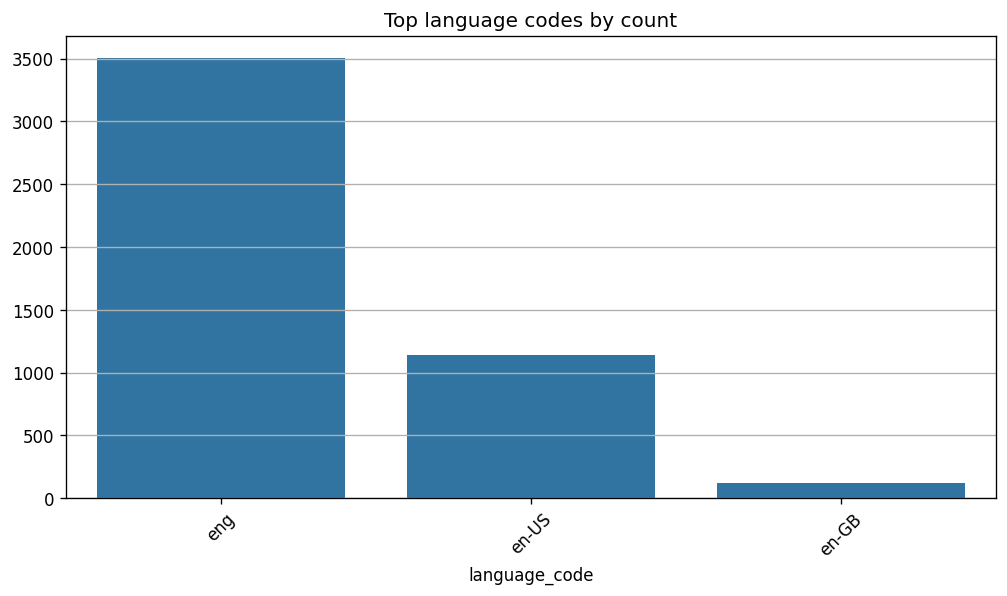

In [9]:
lang_counts = df_raw['language_code'].value_counts(dropna=False).head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.xticks(rotation=45)
plt.title("Top language codes by count")
save_and_show(ARTIFACTS_DIR / "language_code_distribution.png")

## 5. Duplicate checks
We check three kinds of duplicates:
- **Exact title + authors match** (likely exact duplicate)
- **Normalized title + overlapping author** (likely same edition)
- **Exact description match** (could be same book or copy-paste synopsis)

These justify cleaning rules and help decide if extra deduplication is needed.

In [10]:
dups_exact = dup_checks.exact_title_author_dups(df_raw)
print(f"Exact title+author duplicates: {len(dups_exact)}")
if not dups_exact.empty:
    print("Sample pairs of duplicates:")
    print(dups_exact.head(3).to_string(index=False))
dups_exact.to_csv(ARTIFACTS_DIR / "dups_exact_title_authors.csv", index=False)

dups_overlap = dup_checks.title_norm_author_overlap_dups(df_raw)
print(f"Title-normalized + author-overlap duplicates: {len(dups_overlap)}")
if not dups_overlap.empty:
    print("Sample pairs of duplicates:")
    print(dups_overlap.head(3).to_string(index=False))
dups_overlap.to_csv(ARTIFACTS_DIR / "dups_title_norm_author_overlap_pairs.csv", index=False)

dups_desc = dup_checks.same_description_dup(df_raw)
print(f"Same-description groups: {len(dups_desc)}")
if not dups_desc.empty:
    print("Sample groups of duplicates:")
    print(dups_desc.head(3).to_string(index=False))
dups_desc.to_csv(ARTIFACTS_DIR / "dups_same_description_groups.csv", index=False)

Exact title+author duplicates: 0
Title-normalized + author-overlap duplicates: 1
Sample pairs of duplicates:
 title_norm  book_id_i  book_id_j      title_i      title_j    authors_i                       authors_j  year_i  year_j
salem s lot      11590       5413 'Salem's Lot 'Salem's Lot Stephen King Stephen King, Jerry N. Uelsmann  1975.0  2005.0
Same-description groups: 72
Sample groups of duplicates:
 n_rows                                                                    sample_desc_80                                                                                                                                                            distinct_titles   distinct_authors                    years                                 book_ids
      5 This collection bundles all seven romantic suspense titles in Dee Henderson’s be…                  [Danger in the Shadows (O'Malley #0.5), The Guardian (O'Malley #2), The Healer (O'Malley #5), The Negotiator (O'Malley, #1), The Protector 

Run cleaning and validate duplicates removed
python
Copy code

In [23]:
dups_exact_clean = exact_title_author_dups(df_clean)
dups_overlap_clean = title_norm_author_overlap_dups(df_clean)
desc_groups_clean = same_description_groups(df_clean)

print(f"Exact title+author duplicates: {len(dups_exact_clean)}")
print(f"Title-normalized + author-overlap duplicates: {len(dups_overlap_clean)}")
print(f"Same-description groups: {len(desc_groups_clean)}")
print("flip candidates: ", len(author_flip_candidates(df_clean)))
print("Sample pairs of duplicates:")
display(dups_exact_clean.head(3))
display(dups_overlap_clean.head(3))
print("Sample author flip candidates:")
display(author_flip_candidates(df_clean, sample_n=3))

dups_overlap.to_csv(ARTIFACTS_DIR / f"dups_title_norm_author_overlap_pairs.csv", index=False)
desc_groups_clean.to_csv(ARTIFACTS_DIR / f"dups_same_description_groups.csv", index=False)


Exact title+author duplicates: 0
Title-normalized + author-overlap duplicates: 0
Same-description groups: 72
flip candidates:  30
Sample pairs of duplicates:


c:\Users\User\Documents\book-recomendation\src\eda\dup_checks.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,title,authors,book_id,original_publication_year,average_rating


""


Sample author flip candidates:


,book_id,title,authors
1,3,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)","J.K. Rowling, Mary GrandPré"
12,48855,The Diary of a Young Girl,"Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-Doubleday"
13,2429135,"The Girl with the Dragon Tattoo (Millennium, #1)","Stieg Larsson, Reg Keeland"


In [21]:
removed_exact   = max(0, len(dups_exact)   - len(dups_exact_clean))
removed_overlap = max(0, len(dups_overlap) - len(dups_overlap_clean))
removed_desc_groups = max(0, len(desc_groups_clean))

percentage_removed_exact = (removed_exact / len(dups_exact) * 100) if len(dups_exact) > 0 else 100
percentage_removed_overlap = (removed_overlap / len(dups_overlap) * 100) if len(dups_overlap) > 0 else 100
percentage_desc_groups_Identified = (removed_desc_groups / len(dups_desc) * 100) if len(dups_desc) > 0 else 100

md = f"""
### Post-clean dedupe summary

- Exact title+authors duplicates removed: **{removed_exact}**  {percentage_removed_exact:.2f}%
- Title-normalized + author-overlap duplicates removed: **{removed_overlap}** {percentage_removed_overlap:.2f}%
- Same-description groups removed: **{removed_desc_groups}** {percentage_desc_groups_Identified:.2f}%

"""

display(Markdown(md))



### Post-clean dedupe summary

- Exact title+authors duplicates removed: **0**  100.00%
- Title-normalized + author-overlap duplicates removed: **1** 100.00%
- Same-description groups removed: **72** 100.00%



## 6. Numeric feature distributions
Histograms help decide on transformations (e.g., log) or binning for categorical features. Tail-heavy distributions might need normalization.

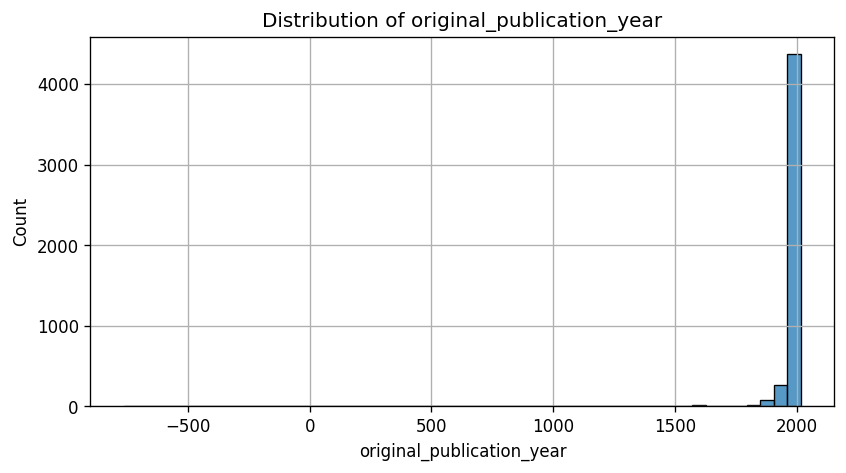

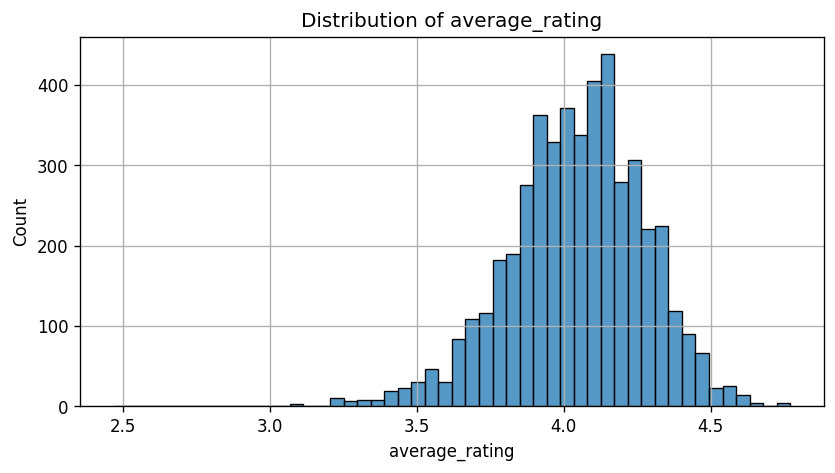

In [14]:
numeric_cols = ["original_publication_year", "average_rating"]
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df_raw[col], kde=False, bins=50)
    plt.title(f"Distribution of {col}")
    save_and_show(ARTIFACTS_DIR / f"{col}_hist.png")

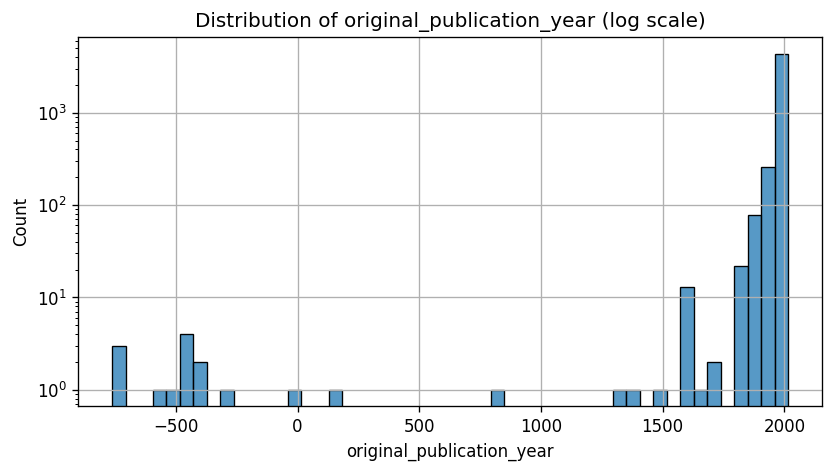

In [15]:
#plot original publicatio yer histogram in log scale the count (y axis not the x axis)
if "original_publication_year" in df_raw.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df_raw["original_publication_year"], kde=False, bins=50)
    plt.yscale('log')
    plt.title("Distribution of original_publication_year (log scale)")
    save_and_show(ARTIFACTS_DIR / "original_publication_year_hist_log.png")

## 7. Text length statistics
We check description length distribution — useful for detecting anomalies (extremely short/long descriptions) and deciding on log-transform or boolean flags.

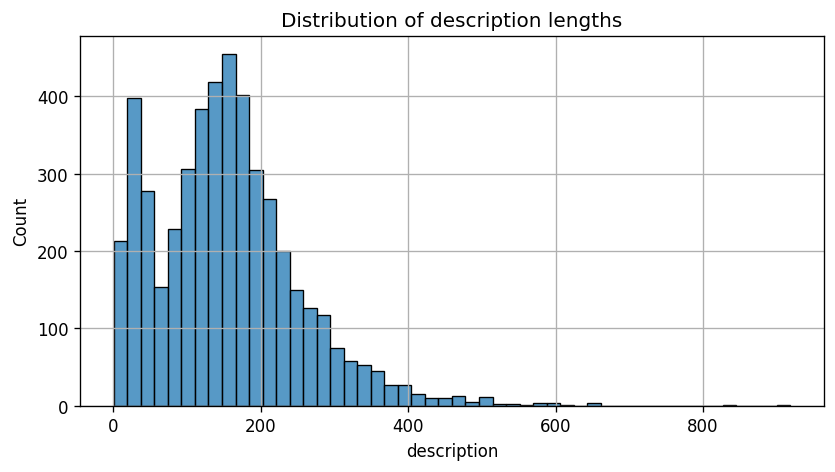

In [16]:
desc_lengths = text_stats.description_length(df_raw)
desc_lengths.to_csv(ARTIFACTS_DIR / "desc_length.csv", index=False)

plt.figure(figsize=(8,4))
sns.histplot(desc_lengths, bins=50)
plt.title("Distribution of description lengths")
save_and_show(ARTIFACTS_DIR / "desc_length_hist.png")

## 8. Vocabulary size estimation
Helps gauge dataset's linguistic richness and potential benefits of NLP preprocessing (stemming, stopword removal).

In [17]:
vocab_size = text_stats.vocab_size(df_raw)
with open(ARTIFACTS_DIR / "vocab_size.txt", "w") as f:
    f.write(str(vocab_size))
print(f"Estimated vocabulary size: {vocab_size}")

Estimated vocabulary size: 37330


## 9. Summary profile report
We save a pandas-profiling-like summary (using describe) for quick reference.

In [18]:
profile = df_raw.describe(include='all')
profile.to_csv(ARTIFACTS_DIR / "profile.csv")
profile

,book_id,authors,original_publication_year,title,language_code,average_rating,image_url,description
count,4.766000e+03,4766,4766.000000,4766,4766,4766.000000,4766,4766
unique,NaN,1893,NaN,4763,3,NaN,3410,4681
top,NaN,Terry Pratchett,NaN,"Private (Private, #1)",eng,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,This collection bundles all seven romantic sus...
freq,NaN,39,NaN,2,3503,NaN,1357,5
mean,5.650215e+06,NaN,1988.510071,NaN,NaN,4.042776,NaN,NaN
std,7.438062e+06,NaN,138.106988,NaN,NaN,0.233440,NaN,NaN
min,1.000000e+00,NaN,-762.000000,NaN,NaN,2.470000,NaN,NaN
25%,4.516375e+04,NaN,1996.000000,NaN,NaN,3.900000,NaN,NaN
50%,5.616825e+05,NaN,2006.000000,NaN,NaN,4.060000,NaN,NaN
75%,1.051807e+07,NaN,2011.000000,NaN,NaN,4.200000,NaN,NaN


### EDA1 auto logic recommendations based on the data

In [19]:
recommendetions = recommend_fe_actions(df_raw)

with open(ARTIFACTS_DIR / "eda1_recommendetions.json", "w", encoding="utf-8") as f:
    json.dump(recommendetions, f, indent=2, ensure_ascii=False)

with open(ARTIFACTS_DIR / "eda1_recommendetions.txt", "w", encoding="utf-8") as f:
    f.write("# EDA1 automatic recommendations\n\n")
    for a in recommendetions["actions"]:
        f.write(f"- {a['feature']}: {a['action']} — {a['why']}\n")

print("Saved:", ARTIFACTS_DIR / "eda1_recommendetions.json")
pd.DataFrame(recommendetions["actions"])

Saved: c:\Users\User\Documents\book-recomendation\artifacts\eda1_prep\eda1_recommendetions.json


,feature,action,why
0,book_id,keep,column book_id has acceptable NaN ratio (0.00%)
1,original_publication_year,keep,column original_publication_year has acceptabl...
2,average_rating,keep,column average_rating has acceptable NaN ratio...
3,language_code,drop,dominated by a single code; low discriminative...
4,desc_length,derive_log1p_and_binary,length is right‑skewed (skew=1.01); add log1p(...
5,author_count,derive_integer_and_binary,author_count is easy signal; add int feature a...
6,original_publication_year,derive_decade_and_modern_flag,year often non‑linear; add decade bucket and m...
7,average_rating,keep_raw_and_add_minmax_0_1,"narrow range [2.47,4.77] (std=0.23); min‑max t..."
8,dedupe_policy,apply_cleaning_rules_before_model,found potential duplicates: {'exact_title_auth...
9,__model_level__,normalize_numeric_for_distance_models,if using cosine/Euclidean similarity on mixed ...


In [20]:
recommendetions_actions = pd.DataFrame(recommendetions["actions"])
pd.set_option('display.max_colwidth', None)
display(recommendetions_actions)


,feature,action,why
0,book_id,keep,column book_id has acceptable NaN ratio (0.00%)
1,original_publication_year,keep,column original_publication_year has acceptable NaN ratio (0.00%)
2,average_rating,keep,column average_rating has acceptable NaN ratio (0.00%)
3,language_code,drop,"dominated by a single code; low discriminative value (top_share=0.735, unique_ratio=0.001)"
4,desc_length,derive_log1p_and_binary,length is right‑skewed (skew=1.01); add log1p(desc_len) and a binary above_median=144.0
5,author_count,derive_integer_and_binary,author_count is easy signal; add int feature and binary above_median=1.0
6,original_publication_year,derive_decade_and_modern_flag,"year often non‑linear; add decade bucket and modern(>=2000). skew=-16.51, median=2006"
7,average_rating,keep_raw_and_add_minmax_0_1,"narrow range [2.47,4.77] (std=0.23); min‑max to [0,1] can stabilize distances"
8,dedupe_policy,apply_cleaning_rules_before_model,"found potential duplicates: {'exact_title_author': 0, 'title_norm_author_overlap': 1, 'same_description_groups': 72}. ensure strict pre‑dedupe to avoid train/test leakage and near‑edition loops"
9,__model_level__,normalize_numeric_for_distance_models,"if using cosine/Euclidean similarity on mixed features, ensure comparable scales (e.g., z‑score ratings, log1p lengths)"
